<div style="background-color: #fff8dc; padding: 10px; border-radius: 5px; line-height: 1.6;">
    
## EDR (REMEDI) | Quick Dashboard

### Import modules

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from IPython.display import display, HTML

import plotly.graph_objects as go
import ipywidgets as w

### Load and merge tables:

In [4]:

# --- Load EDR tables ---
#path       = '/home/ipetrova/IRINA_PETROVA/1_Work/0_UNEP/OGMP2.0/OGMP_database/0_OGMP_Jup_Notebooks/Jupiter_notebooks/OGMP_locations_plotting/DATA_input/Emission_data/'
#file_name = 'IMEO_Studies_Master_File_V4_Draft.xlsx'
file_name = 'IMEO_Studies_Master_File_V5.xlsx'

# read all sheets to dict of dataframes
#dfs = pd.read_excel(path+file_name, sheet_name=None)
dfs = pd.read_excel(file_name, sheet_name=None)

# Get data from two tables:
df_data = dfs['Measurement_ID'].loc[:, : 'FLAG -Eye_on_Methane'].copy()
df_loc  = dfs['Location_ID'].copy()

# make sure id_location is string in both
df_data["id_location"]   = df_data["id_location"].astype(str)
df_loc["id_location"]    = df_loc["id_location"].astype(str)

# merge tables:
df_merged = df_data.merge(
    df_loc,
    on="id_location",
    how="left"    # keeps length of filtered_upstr unchanged
)


### Filtering

In [5]:
# --- data selection ---

# (1) Filter rows by Sector | Subsector | spatial scale:

mask = (df_merged['sector'].astype(str).str.strip() == 'Energy') & \
    (df_merged['subsector'].astype(str).str.strip() == 'Fugitive Emissions from Fuels')
                

filtered = df_merged.loc[mask].copy()
filtered.keys()

# (2) Handle nans in other tabs:

for name in filtered.keys():
    filtered[name] = filtered[name].fillna("missing value")

# --- Housekeeping ---

# (1) Rename columns to clearer names
rename_map = {
    'min.lat':  'lat_min',
    'min. long': 'lon_min',
    'max. lat':  'lat_max',
    'max.long': 'lon_max'}

filtered = filtered.rename(columns=rename_map)

# (2) Add new column: measurement_year:
filtered['measurement_start'] = pd.to_datetime( filtered['measurement_start'],
    format='%Y-%m-%d %H:%M:%S',   # faster & strict for your format
    errors='coerce')

# Extract year; keep missing as <NA>
filtered['year'] = filtered['measurement_start'].dt.year.astype('Int64')

# (optional) see how many couldn't be parsed
failed = filtered['measurement_start'].isna().sum()
print(f"Unparsed/empty dates: {failed}")


Unparsed/empty dates: 62


In [2]:
#display(HTML(filtered.to_html()))

### To illustrate whats left behind in the sector == Energy

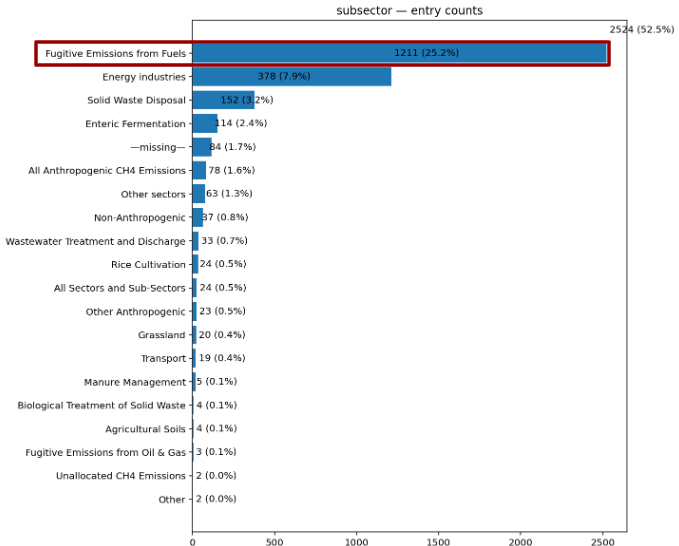

### Run a Dashboard

In [117]:

# ========= SOURCE DATA =========
# Uses your DataFrame named `filtered`
df = filtered.copy()

# ========= SETTINGS =========
FILTER_COLS = ['sub-subsector', 'activity', 'spatial_resolution', 'OGMP', 'year']
COORD_COLS  = ['lat_min','lon_min','lat_max','lon_max']

# --- Coerce coordinate columns to numeric (do not drop anything here) ---
for c in COORD_COLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# --- (Optional) normalize longitudes to [-180, 180] for nicer world plotting ---
for c in ['lon_min', 'lon_max']:
    if c in df.columns:
        df[c] = ((df[c] + 180) % 360) - 180

# --- Make measurement_start a datetime if possible (for nicer popup text) ---
if 'measurement_start' in df.columns:
    df['measurement_start'] = pd.to_datetime(df['measurement_start'], errors='coerce')

# --- Ensure 'year' column exists (nullable int) ---
if 'year' not in df.columns and 'measurement_start' in df.columns:
    df['year'] = df['measurement_start'].dt.year.astype('Int64')

# ========= HELPERS =========
def options_from_series(s: pd.Series):
    """Build dropdown options with 'All' and 'missing'."""
    opts = ["All"]
    if s.isna().any():
        opts.append("missing")
    vals = s.dropna().unique().tolist()
    try:
        vals_num = [int(v) for v in vals]
        vals = [str(v) for v in sorted(vals_num)]
    except Exception:
        vals = sorted([str(v) for v in vals])
    return opts + vals

def filter_step(d: pd.DataFrame, col: str, value):
    """Apply a single dropdown filter to DataFrame."""
    if col not in d.columns or value == "All":
        return d
    if value == "missing":
        return d[d[col].isna()]
    return d[d[col].astype(str) == str(value)]

def filtered_for_plot():
    """Apply all filters to the dataframe (for plotting)."""
    d = df.copy()
    d = filter_step(d, 'sub-subsector',        dd_subsub.value)
    d = filter_step(d, 'activity',             dd_act.value)
    d = filter_step(d, 'spatial_resolution',   dd_spat.value)
    d = filter_step(d, 'OGMP',                 dd_ogmp.value)
    d = filter_step(d, 'year',                 dd_year.value)
    return d

def fmt_measurement_start(val):
    """Format measurement_start nicely for hover."""
    if pd.isna(val):
        return ""
    if isinstance(val, pd.Timestamp):
        return val.strftime("%Y-%m-%d %H:%M:%S")
    return str(val)

def _safe_str(r, col):
    """Return '' if column missing/NaN, else string value."""
    if col not in r or pd.isna(r[col]):
        return ""
    return str(r[col])

def build_hover(r):
    """Compose hover HTML for both rectangles and points."""
    notes   = _safe_str(r, 'notes')
    mstart  = fmt_measurement_start(r['measurement_start']) if 'measurement_start' in r else ""
    tres    = _safe_str(r, 'temporal_resolution')
    ogmp    = _safe_str(r, 'OGMP')
    year_   = _safe_str(r, 'year')
    paper   = _safe_str(r, 'paper_id')
    actv    = _safe_str(r, 'activity')
    emis    = _safe_str(r, 'emission_source')
    subsec  = _safe_str(r, 'sub-subsector')   # NEW: include sub-subsector

    def fmtv(v, n=5):
        try: return f"{float(v):.{n}f}"
        except: return ""

    hover = (
        f"<b>paper_id</b>: {paper}<br>"
        f"<b>activity</b>: {actv}<br>"
        f"<b>emission_source</b>: {emis}<br>"
        f"<b>sub-subsector</b>: {subsec}<br>"   # NEW
        f"<b>notes</b>: {notes}<br>"
        f"<b>measurement_start</b>: {mstart}<br>"
        f"<b>temporal_resolution</b>: {tres}<br>"
        f"<b>OGMP</b>: {ogmp}<br>"
        f"<b>year</b>: {year_}<br>"
        f"<b>lat_min</b>: {fmtv(r.get('lat_min'))}<br>"
        f"<b>lon_min</b>: {fmtv(r.get('lon_min'))}<br>"
        f"<b>lat_max</b>: {fmtv(r.get('lat_max'))}<br>"
        f"<b>lon_max</b>: {fmtv(r.get('lon_max'))}"
    )
    return hover

def available_corners(row):
    """Return list of available corners (lon, lat) among the four."""
    corners = []
    if pd.notna(row.get('lon_min')) and pd.notna(row.get('lat_min')):
        corners.append( (float(row['lon_min']), float(row['lat_min'])) )
    if pd.notna(row.get('lon_max')) and pd.notna(row.get('lat_max')):
        corners.append( (float(row['lon_max']), float(row['lat_max'])) )
    if pd.notna(row.get('lon_max')) and pd.notna(row.get('lat_min')):
        corners.append( (float(row['lon_max']), float(row['lat_min'])) )
    if pd.notna(row.get('lon_min')) and pd.notna(row.get('lat_max')):
        corners.append( (float(row['lon_min']), float(row['lat_max'])) )
    return corners

# ========= WIDGETS =========
dd_subsub = w.Dropdown(
    options=options_from_series(df['sub-subsector']) if 'sub-subsector' in df.columns else ["All"],
    value="All",
    description="sub-subsector",
    layout=w.Layout(width='100%')
)
dd_act = w.Dropdown(
    options=options_from_series(df['activity']) if 'activity' in df.columns else ["All"],
    value="All",
    description="activity",
    layout=w.Layout(width='100%')
)
dd_spat = w.Dropdown(
    options=options_from_series(df['spatial_resolution']) if 'spatial_resolution' in df.columns else ["All"],
    value="All",
    description="spatial_resolution",
    layout=w.Layout(width='100%')
)
dd_ogmp = w.Dropdown(
    options=options_from_series(df['OGMP']) if 'OGMP' in df.columns else ["All"],
    value="All",
    description="OGMP",
    layout=w.Layout(width='100%')
)
dd_year = w.Dropdown(
    options=options_from_series(df['year']) if 'year' in df.columns else ["All"],
    value="All",
    description="year",
    layout=w.Layout(width='100%')
)

# Toggle to show/hide centers
tg_centers = w.ToggleButton(
    value=False,
    description="Show centers",
    tooltip="Toggle plotting of centers for boxes with 4 coords",
    icon="bullseye",
    layout=w.Layout(width='100%')
)

out = w.Output()

# ========= PLOT UPDATE =========
def update_plot(*args):
    with out:
        out.clear_output()

        d = filtered_for_plot().copy()

        fig = go.Figure()
        fig.update_geos(
            projection_type="natural earth",
            showcountries=False,    # NEW: remove country boundaries
            showcoastlines=False,   # NEW: remove coastline boundaries
            showframe=False,        # NEW: remove projection frame
            showrivers=False,       # NEW: no river lines
            showlakes=False,        # NEW: no lake outlines
            showocean=True,         # NEW: color ocean
            oceancolor="darkgray",  # NEW: ocean = dark gray
            showland=True,          # NEW: land visible
            landcolor="black"       # NEW: land = black
        )
        fig.update_layout(
            height=600,
            margin=dict(l=0, r=0, t=30, b=0),
            paper_bgcolor="white",  # optional: blend outside area with ocean
            plot_bgcolor="white"    # optional: blend plot area with ocean
        )

        boxes = 0
        dots  = 0
        centers_lon = []
        centers_lat = []
        centers_hover = []

        for _, r in d.iterrows():
            hover = build_hover(r)
            all_four = all(pd.notna(r.get(c)) for c in COORD_COLS)
            corners = available_corners(r)

            if all_four:
                # rectangle (closed polyline)
                lons = [r.lon_min, r.lon_max, r.lon_max, r.lon_min, r.lon_min, None]
                lats = [r.lat_min, r.lat_min, r.lat_max, r.lat_max, r.lat_min, None]
                fig.add_trace(go.Scattergeo(
                    lon=lons, lat=lats,
                    mode='lines',
                    line=dict(width=1),
                    text=[hover]*len(lons),
                    hovertemplate="%{text}<extra></extra>",
                    name="bbox"
                ))
                boxes += 1

                # collect center for optional plotting
                centers_lon.append((float(r.lon_min) + float(r.lon_max)) / 2.0)
                centers_lat.append((float(r.lat_min) + float(r.lat_max)) / 2.0)
                centers_hover.append(hover)

            elif len(corners) == 1:
                # single available corner -> dot
                lon, lat = corners[0]
                fig.add_trace(go.Scattergeo(
                    lon=[lon], lat=[lat],
                    mode='markers',
                    marker=dict(size=6),
                    text=[hover],
                    hovertemplate="%{text}<extra></extra>",
                    name="point"
                ))
                dots += 1

            # else: 2 or 3 corners -> skip per instruction

        # Optional centers layer
        if tg_centers.value and len(centers_lon) > 0:
            fig.add_trace(go.Scattergeo(
                lon=centers_lon,
                lat=centers_lat,
                mode='markers',
                marker=dict(size=7, symbol="x"),
                text=centers_hover,
                hovertemplate="%{text}<extra></extra>",
                name="center"
            ))
        
        fig.update_layout(title=f"Global Boxes — {boxes} box(es), {dots} point(s){' + centers' if tg_centers.value else ''}")
        fig.show()

# ========= CASCADING LOGIC =========
def on_subsub_change(change):
    refresh_activity_options()
    refresh_spatial_options()
    update_plot()

def on_activity_change(change):
    refresh_spatial_options()
    update_plot()

def on_spatial_change(change):
    update_plot()

def on_ogmp_change(change):
    refresh_activity_options()
    refresh_spatial_options()
    update_plot()

def on_year_change(change):
    refresh_activity_options()
    refresh_spatial_options()
    update_plot()

def on_toggle_centers(change):
    update_plot()

dd_subsub.observe(on_subsub_change, names='value')
dd_act.observe(on_activity_change, names='value')
dd_spat.observe(on_spatial_change, names='value')
dd_ogmp.observe(on_ogmp_change, names='value')
dd_year.observe(on_year_change, names='value')
tg_centers.observe(on_toggle_centers, names='value')

# First-time cascade + draw
def refresh_activity_options():
    d = filter_step(df, 'sub-subsector', dd_subsub.value)
    d = filter_step(d,  'OGMP',          dd_ogmp.value)
    d = filter_step(d,  'year',          dd_year.value)
    new_opts = options_from_series(d['activity']) if 'activity' in d.columns else ["All"]
    prev = dd_act.value if dd_act.value in new_opts else "All"
    dd_act.options = new_opts
    dd_act.value = prev

def refresh_spatial_options():
    d = filter_step(df, 'sub-subsector', dd_subsub.value)
    d = filter_step(d,  'activity',      dd_act.value)
    d = filter_step(d,  'OGMP',          dd_ogmp.value)
    d = filter_step(d,  'year',          dd_year.value)
    new_opts = options_from_series(d['spatial_resolution']) if 'spatial_resolution' in d.columns else ["All"]
    prev = dd_spat.value if dd_spat.value in new_opts else "All"
    dd_spat.options = new_opts
    dd_spat.value = prev

refresh_activity_options()
refresh_spatial_options()
update_plot()

# ========= LAYOUT (single column) =========
controls = w.VBox([
    dd_subsub,
    dd_act,
    dd_spat,
    dd_ogmp,
    dd_year,
    tg_centers
], layout=w.Layout(width='40%'))  # adjust width as needed

display(w.VBox([
    controls,
    out
]))
